In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open("./data/train.csv") as f:
    train_data = pd.read_csv(f)
with open("./data/test.csv") as f:
    test_data = pd.read_csv(f)
with open("./data/gender_submission.csv") as f:
    example_submission = pd.read_csv(f)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [8]:
train_copy = train_data.copy()
test_copy = test_data.copy()

In [9]:
train_copy["Cabin"] = train_copy["Cabin"].apply(lambda x: 1 if type(x) == str else 0)
test_copy["Cabin"] = test_copy["Cabin"].apply(lambda x: 1 if type(x) == str else 0)

In [10]:
train_copy = train_copy.dropna(subset=["Embarked"])

In [11]:
train_dummies = pd.get_dummies(train_copy, columns=["Sex", "Embarked"], drop_first=True)
test_dummies = pd.get_dummies(test_copy, columns=["Sex", "Embarked"], drop_first=True)

In [12]:
features = train_dummies.drop(["Survived", "PassengerId", "Name", "Ticket"], axis=1)
target = train_dummies["Survived"]

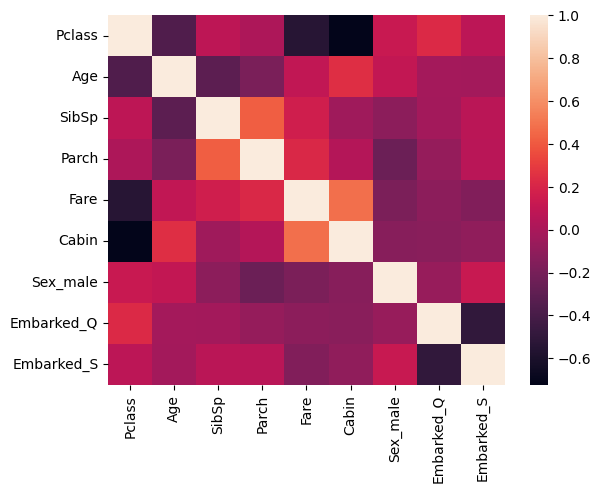

In [13]:
corr_matrix = features.corr()
sns.heatmap(corr_matrix)
plt.show()

In [14]:
test_set = test_dummies.drop(["PassengerId", "Name", "Ticket"], axis=1)

In [15]:
features.info()
print("")
target.info()
print("")
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      889 non-null    int64  
 1   Age         712 non-null    float64
 2   SibSp       889 non-null    int64  
 3   Parch       889 non-null    int64  
 4   Fare        889 non-null    float64
 5   Cabin       889 non-null    int64  
 6   Sex_male    889 non-null    bool   
 7   Embarked_Q  889 non-null    bool   
 8   Embarked_S  889 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 51.2 KB

<class 'pandas.core.series.Series'>
Index: 889 entries, 0 to 890
Series name: Survived
Non-Null Count  Dtype
--------------  -----
889 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclas

In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(features[["Age"]])
features["Age"] = imputer.transform(features[["Age"]])
test_set["Age"] = imputer.transform(test_set[["Age"]])

In [17]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(test_set[["Fare"]])
test_set["Fare"] = imputer.transform(test_set[["Fare"]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0
)

In [19]:
rf = RandomForestClassifier(random_state=0)

In [20]:
cv_params = {
    "n_estimators": [50, 100, 200],

    "max_depth": [3, 5, 10],

    "min_samples_leaf": [0.5, 1, 2, 5],

    "min_samples_split": [0.001, 0.01, 0.05],

    "max_features": ["sqrt"],

    "max_samples": [0.5, 0.9],
}

In [21]:
rf_grid = GridSearchCV(rf, param_grid=cv_params, cv=5, refit="f1", n_jobs=-1, verbose=1)

In [22]:
rf_grid.fit(X_train, y_train)


print(rf_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\aloke.de\Documents\titanic\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'n_estimators': 100}


In [23]:
rf_optimal = RandomForestClassifier(**rf_grid.best_params_, random_state=0)
rf_optimal.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=0.01, random_state=0)

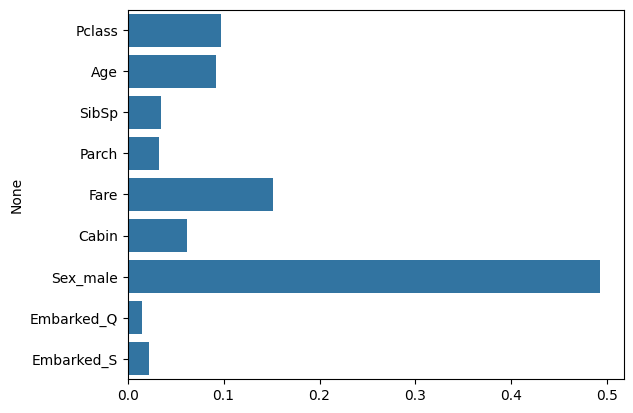

In [24]:
sns.barplot(x=rf_optimal.feature_importances_, y=features.columns)
plt.show()

In [25]:
# Predict on test subset
y_pred = rf_optimal.predict(X_test)

In [26]:
# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.7640449438202247
F1 Score: 0.676923076923077
Precision: 0.7719298245614035
Recall: 0.6027397260273972


In [27]:
predictions = rf_optimal.predict(test_set)

In [28]:
output = pd.DataFrame({"PassengerId": test_copy.PassengerId, "Survived": predictions})
output.to_csv("prediction.csv", index=False)